# Scattering Net + XGBoost

In [1]:
import torch, torchvision
import sys, os
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms, datasets
from matplotlib import cm
from torch.utils.data.dataset import TensorDataset
from torch.utils.data.dataloader import DataLoader

from kymatio import Scattering2D
from kymatio import HarmonicScattering3D

import time

In [2]:
torch.cuda.is_available()

True

In [3]:
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
flip_axes = lambda tens: tens.permute(1, 2, 0)
semicond_dataset = datasets.ImageFolder(root='/home/abnv/math6380o/project_2/train', 
                                        transform=transforms.Compose(
                                            [
                                                transforms.ToTensor()
                                            ]
                                        )
                                       )
dataset_loader = torch.utils.data.DataLoader(semicond_dataset,
                                             batch_size=16, shuffle=True,
                                             num_workers=4)

In [4]:
def imshow(inp, title=None, normalize=True):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, interpolation="bilinear", cmap=cm.RdYlGn, aspect="auto")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [10]:
batch_id, (features, labels) = next(enumerate(dataset_loader))

In [6]:
features.shape

torch.Size([16, 3, 224, 224])

In [7]:
feature_grid = torchvision.utils.make_grid(features, nrow=4)

In [8]:
feature_grid.shape

torch.Size([3, 906, 906])

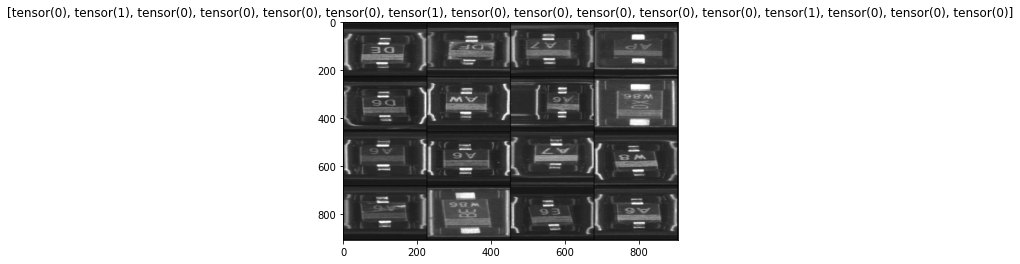

In [9]:
imshow(feature_grid, title=[x for x in labels], normalize=False)

In [10]:
from sklearn import preprocessing

In [11]:
scaler = preprocessing.StandardScaler()

In [12]:
dataset_loader_new = torch.utils.data.DataLoader(semicond_dataset,
                                                batch_size=100, shuffle=True,
                                                num_workers=10)

In [14]:
batch_id, (features, labels) = next(enumerate(dataset_loader_new))

In [15]:
import time
times = 10

In [16]:
scattering = HarmonicScattering3D(J=2, shape=(3, 224, 224), L=2)

In [46]:
t_start = time.time()

scattering.cuda()
features = features.cuda()

for _ in range(times):
    scattering(features)
    
torch.cuda.synchronize()

t_elapsed = time.time() - t_start

fmt_str = 'Elapsed time: {:2f} [s / {:d} evals], avg: {:.2f} (s/batch)'
print(fmt_str.format(t_elapsed, times, t_elapsed/times))

Elapsed time: 6.256675 [s / 10 evals], avg: 0.63 (s/batch)


In [47]:
del(scattering)

In [48]:
torch.cuda.empty_cache()

## Feature extraction using Scattering Net

In [18]:
dataloader = DataLoader(semicond_dataset, batch_size=100, shuffle=True, num_workers=10)
scattering = HarmonicScattering3D(J=2, shape=(3, 224, 224), L=2)
scattering.cuda()

In [19]:
feat_coll = []
label_coll = []
save_to_disk = True
train = True

for batch_id, [features, labels] in enumerate(dataloader):
    # sample is a list with the first element corresponding to the images
    print("Batch {}, features shape: {}, labels shape: {}".format(batch_id, features.shape, labels.shape))
    features = features.cuda()

    t1 = time.time()
    out = scattering(features)
    t2 = time.time()
    print("Output shape: {}, Time taken: {}".format(out.shape, t2 - t1))

    # move output, features and labels back to the CPU to prevent a memory leak and release memory from GPU
    out = out.to("cpu")
    features = features.to("cpu")
    # do not need to move labels to GPU because we are not doing any computation on them
    # labels = labels.to("cpu")

    out = torch.flatten(out, start_dim=1)
    print("Flattend output shape: {}".format(out.shape))

    feat_coll.append(out)
    label_coll.append(labels)

out_features = torch.flatten(torch.stack(feat_coll), start_dim=0, end_dim=1)
out_labels = torch.flatten(torch.stack(label_coll), start_dim=0, end_dim=1)

print("The final features matrix has shape: {}".format(out_features.shape))

if save_to_disk:
    # save as TensorDataset
    out_dataset = TensorDataset(out_features, out_labels)
    if train:
        prefix = "train"
    else:
        prefix = "test"
    filename = "{}_{}_dataset.pt".format(prefix, scattering.__class__.__name__)
    torch.save(out_dataset, filename)
    print("Saved features at {}/{}".format(os.getcwd(), filename))

Batch 0, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.8869566917419434
Flattend output shape: torch.Size([100, 56448])
Batch 1, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6017942428588867
Flattend output shape: torch.Size([100, 56448])
Batch 2, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6041741371154785
Flattend output shape: torch.Size([100, 56448])
Batch 3, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6034724712371826
Flattend output shape: torch.Size([100, 56448])
Batch 4, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1,

Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5940577983856201
Flattend output shape: torch.Size([100, 56448])
Batch 39, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5949130058288574
Flattend output shape: torch.Size([100, 56448])
Batch 40, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6050777435302734
Flattend output shape: torch.Size([100, 56448])
Batch 41, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5965313911437988
Flattend output shape: torch.Size([100, 56448])
Batch 42, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5967428684234619
Flattend output shape: torch.Size([100, 564

Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5955519676208496
Flattend output shape: torch.Size([100, 56448])
Batch 77, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5934538841247559
Flattend output shape: torch.Size([100, 56448])
Batch 78, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5952208042144775
Flattend output shape: torch.Size([100, 56448])
Batch 79, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5933151245117188
Flattend output shape: torch.Size([100, 56448])
Batch 80, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.594778299331665
Flattend output shape: torch.Size([100, 5644

Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5951919555664062
Flattend output shape: torch.Size([100, 56448])
Batch 115, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5934658050537109
Flattend output shape: torch.Size([100, 56448])
Batch 116, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.593041181564331
Flattend output shape: torch.Size([100, 56448])
Batch 117, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5946681499481201
Flattend output shape: torch.Size([100, 56448])
Batch 118, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5931346416473389
Flattend output shape: torch.Size([100, 

Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5968883037567139
Flattend output shape: torch.Size([100, 56448])
Batch 153, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5951285362243652
Flattend output shape: torch.Size([100, 56448])
Batch 154, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.59602952003479
Flattend output shape: torch.Size([100, 56448])
Batch 155, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5942683219909668
Flattend output shape: torch.Size([100, 56448])
Batch 156, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5957269668579102
Flattend output shape: torch.Size([100, 5

Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6153926849365234
Flattend output shape: torch.Size([100, 56448])
Batch 191, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6254880428314209
Flattend output shape: torch.Size([100, 56448])
Batch 192, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6158590316772461
Flattend output shape: torch.Size([100, 56448])
Batch 193, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5937566757202148
Flattend output shape: torch.Size([100, 56448])
Batch 194, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.597959041595459
Flattend output shape: torch.Size([100, 

Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6009891033172607
Flattend output shape: torch.Size([100, 56448])
Batch 229, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5936019420623779
Flattend output shape: torch.Size([100, 56448])
Batch 230, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6137058734893799
Flattend output shape: torch.Size([100, 56448])
Batch 231, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5931639671325684
Flattend output shape: torch.Size([100, 56448])
Batch 232, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6130678653717041
Flattend output shape: torch.Size([100,

Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6129274368286133
Flattend output shape: torch.Size([100, 56448])
Batch 267, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6155834197998047
Flattend output shape: torch.Size([100, 56448])
Batch 268, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6565654277801514
Flattend output shape: torch.Size([100, 56448])
Batch 269, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.5996906757354736
Flattend output shape: torch.Size([100, 56448])
Batch 270, features shape: torch.Size([100, 3, 224, 224]), labels shape: torch.Size([100])
Output shape: torch.Size([100, 6, 3, 1, 56, 56]), Time taken: 0.6105811595916748
Flattend output shape: torch.Size([100,

In [5]:
def get_stored_dataset(filename, train=True): 
    loaded_dataset = torch.load(filename)
    features = loaded_dataset[:][0]
    labels = loaded_dataset[:][1]

    return features, labels

In [6]:
filename = "train_HarmonicScattering3D_dataset.pt"
out_features, out_labels = get_stored_dataset(filename)

### Classification with XGBoost

In [7]:
import xgboost as xgb
import pickle
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error

from math import sqrt

In [8]:
labels = out_labels.numpy()
features = out_features.numpy()
features.shape, labels.shape

((30000, 56448), (30000,))

In [9]:
_, counts = np.unique(labels, return_counts=True)

In [10]:
pos_label_counts = sum([1 for i in range(len(labels)) if labels[i] == 1])
neg_label_counts = sum([1 for i in range(len(labels)) if labels[i] == 0])

In [11]:
scale_pos_weights = neg_label_counts/pos_label_counts
scale_pos_weights

9.0

In [12]:
"""params = {}
params["objective"] = "binary:logistic"
params["verbosity"] = 2
params["gamma"] = 10
params["max_depth"] = 4
params["subsample"] = 0.5
params["colsample_bytree"] = 0.5
params["colsample_bylevel"] = 0.5
params["colsample_bynode"] = 0.5
params["tree_method"] = "gpu_hist"
params["scale_pos_weight"] = scale_pos_weights
"""

'params = {}\nparams["objective"] = "binary:logistic"\nparams["verbosity"] = 2\nparams["gamma"] = 10\nparams["max_depth"] = 4\nparams["subsample"] = 0.5\nparams["colsample_bytree"] = 0.5\nparams["colsample_bylevel"] = 0.5\nparams["colsample_bynode"] = 0.5\nparams["tree_method"] = "gpu_hist"\nparams["scale_pos_weight"] = scale_pos_weights\n'

Scikit learn APOI

In [13]:
xgb_model = xgb.XGBClassifier(
    max_depth = 3, 
    learning_rate = 0.1, 
    n_estimators = 100, 
    verbosity = 2, 
    objective = "binary:logistic",
    booster = "gbtree",
    tree_method = "gpu_hist",
    gamma = 10,
    subsample = 0.5,
    colsample_bytree = 0.5,
    colsample_bylevel = 0.5,
    colsample_bynode = 0.5,
    scale_pos_weight = scale_pos_weights
)

In [ ]:
trained_model = xgb_model.fit(features, labels)

# Transfer Learning

In [38]:
from fastai import *
from fastai.callbacks import *
from fastai.vision import *

In [8]:
data = ImageDataBunch.from_folder("/home/abnv/math6380o/project_2/train", valid_pct=0.2).normalize(imagenet_stats)

In [7]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

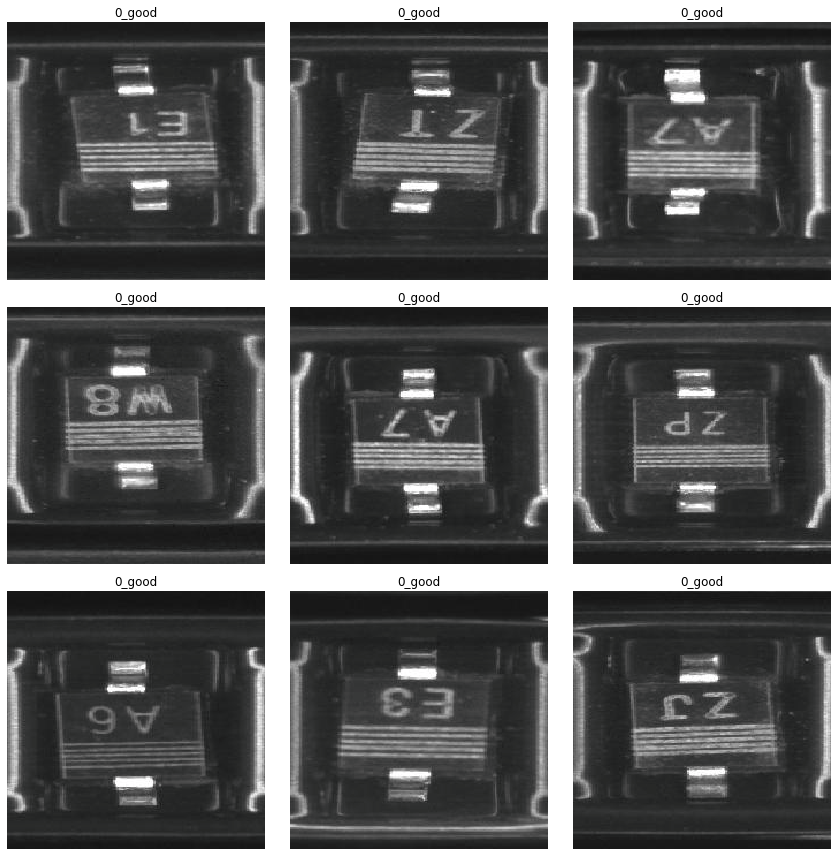

In [9]:
data.show_batch(rows=3)

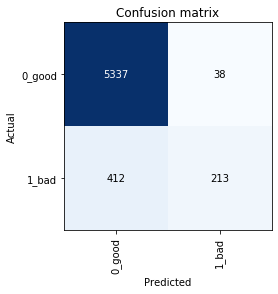

In [13]:
learner.save('test_model')

interp = ClassificationInterpretation.from_learner(learner)

interp.plot_confusion_matrix()

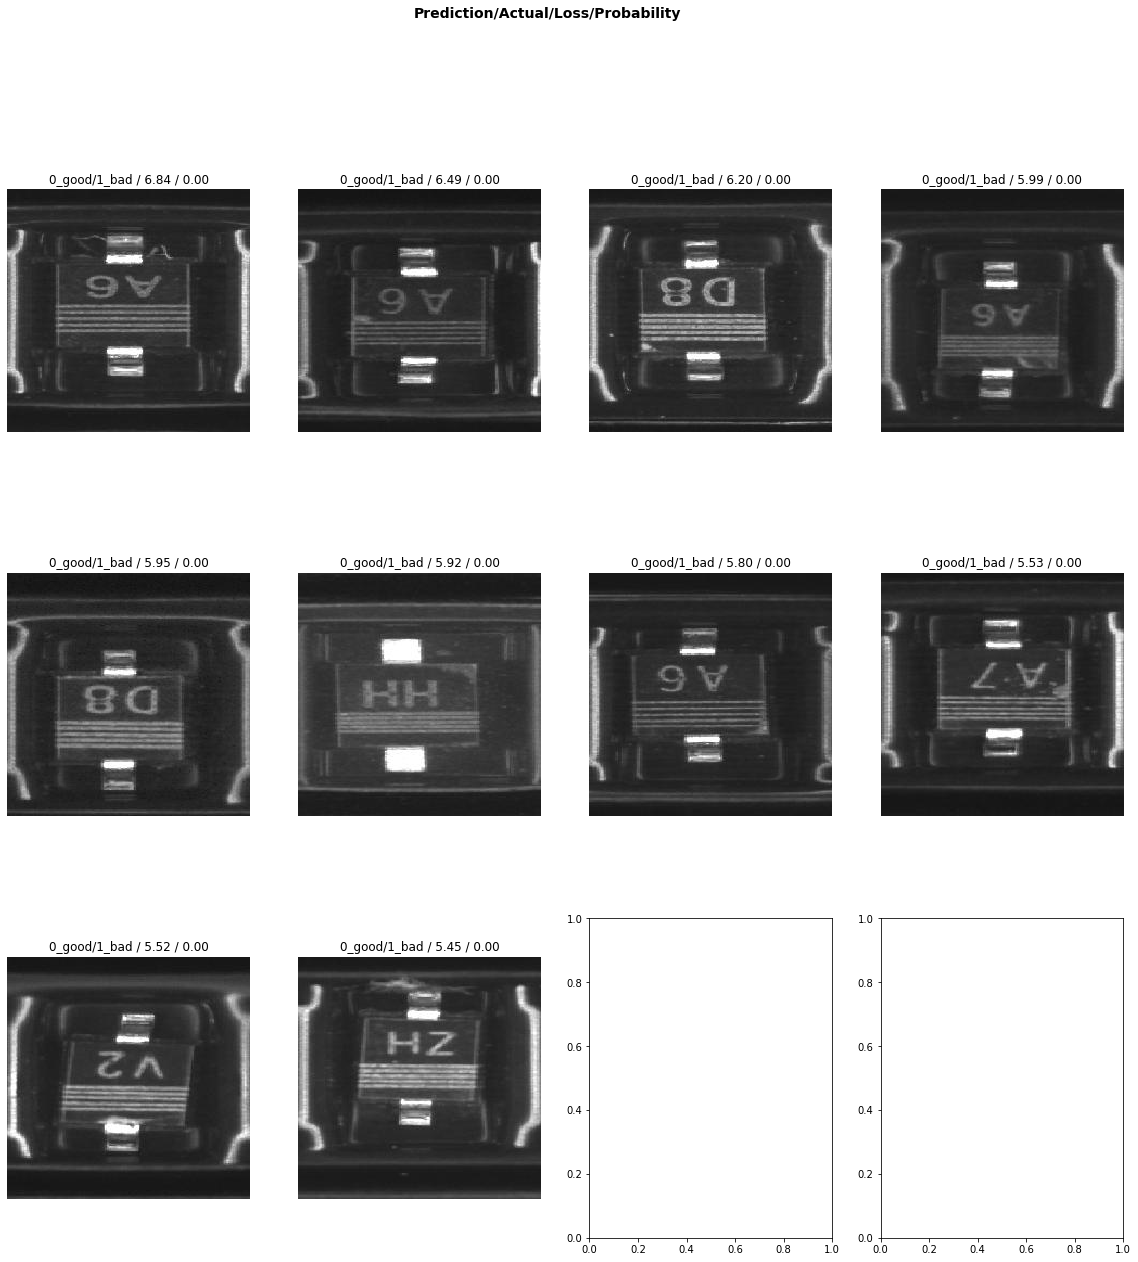

In [14]:
interp.plot_top_losses(10, figsize=(20,20))

In [2]:
data_new = ImageDataBunch.from_folder("/home/abnv/math6380o/project_2/train", valid_pct=0.2).normalize(imagenet_stats)

data_new

ImageDataBunch;

Train: LabelList (24000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1_bad,1_bad,1_bad,1_bad,1_bad
Path: /home/abnv/math6380o/project_2/train;

Valid: LabelList (6000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0_good,0_good,1_bad,0_good,0_good
Path: /home/abnv/math6380o/project_2/train;

Test: None

In [36]:
data_new.train_dl.dl

(array([21640.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,  2360.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

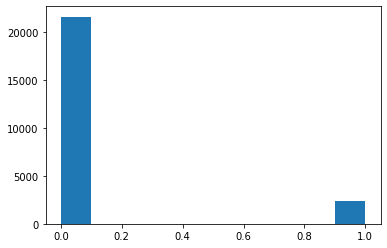

In [37]:
labels = []
for img,target in data_new.train_dl.dl:
    labels.append(target)
labels = torch.cat(labels)
plt.hist(labels)

In [6]:
np.bincount([data_new.train_dl.dataset.y[i].data for i in range(len(data_new.train_dl.dataset))])

array([21592,  2408])

In [7]:
labels

tensor([1, 0, 0,  ..., 0, 0, 0])

In [8]:
type(data_new.train_dl.dataset.y.items)

numpy.ndarray

In [9]:
from torch.utils.data.sampler import WeightedRandomSampler

In [25]:
# total number of items in the dataset for each label?
"""
train_labels = data_new.train_dl.dataset.y.items
_, counts    = np.unique(train_labels,return_counts=True)

print(counts, train_labels)
type(counts)

1./counts

class_weights = 1./counts
weights       = class_weights[train_labels]

type(class_weights)

label_counts = np.bincount([data_new.train_dl.dataset.y[i].data for i in range(len(data_new.train_dl.dataset))])

label_counts

total_len_oversample = int(data_new.c*np.max(label_counts)) #WHY????

print(type(total_len_oversample), total_len_oversample)
"""
accuracy

<function fastai.metrics.accuracy(input: torch.Tensor, targs: torch.Tensor) -> <function NewType.<locals>.new_type at 0x7f1e84049170>>

In [44]:
learn = cnn_learner(
    data_new, 
    models.resnet18, 
    metrics=[error_rate], 
    callback_fns = [
        partial(callbacks.OverSamplingCallback),
        #partial(callbacks.EarlyStoppingCallback, monitor="error_rate", min_delta=0.0001, patience=3),
        partial(callbacks.ReduceLROnPlateauCallback, monitor="valid_loss", mode="auto", patience=3, min_delta=0.01)
    ],
    opt_func = optim.Adam
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 3.98E-03


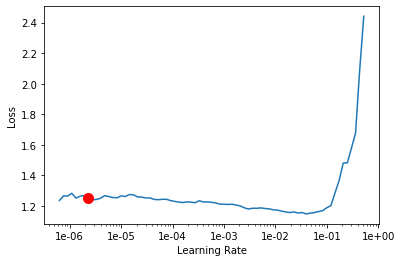

In [45]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [46]:
learn.fit_one_cycle(5, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.450160,0.324681,0.123167,00:40
1,0.202839,0.251063,0.087500,00:40
2,0.132179,0.262415,0.088500,00:40
3,0.074718,0.264460,0.070500,00:39
4,0.055387,0.263916,0.061667,00:39


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.29E-07


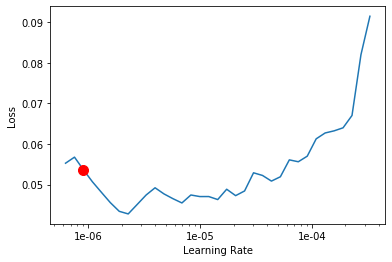

In [47]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [48]:
learn.fit(25, 1e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.047513,0.254561,0.060667,00:54
1,0.039564,0.254909,0.056667,00:54
2,0.029035,0.259724,0.053500,00:54
3,0.028723,0.244268,0.060333,00:54
4,0.024886,0.246691,0.050833,00:54
5,0.018345,0.251380,0.050333,00:54
6,0.019953,0.244966,0.051333,00:54
7,0.019792,0.243511,0.054500,00:54
8,0.011773,0.253358,0.050333,00:55
9,0.013889,0.249706,0.051500,00:55


In [49]:
learn.export("resnet18_25ep_oversampling_no_transforms.pkl")

In [52]:
learn.path

PosixPath('/home/abnv/math6380o/project_2/train')

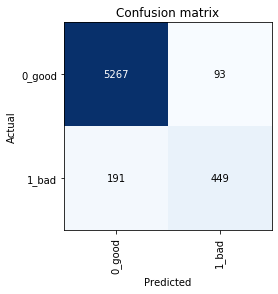

In [50]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

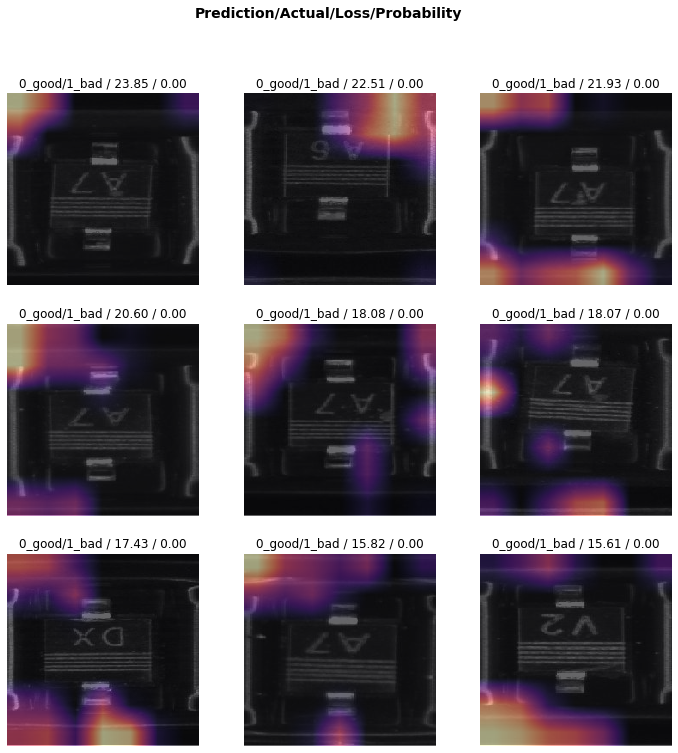

In [51]:
interp.plot_top_losses(9, heatmap=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


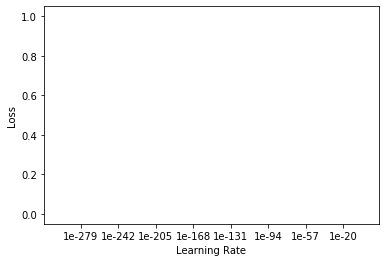

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10,2.5e-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.004057,0.211127,0.975500,00:54
1,0.021797,0.138105,0.975000,00:54
2,0.026391,0.119212,0.974167,00:56
3,0.037742,0.137475,0.976333,00:54
4,0.029054,0.129194,0.975167,00:54


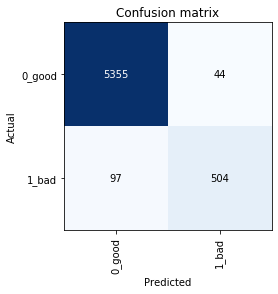

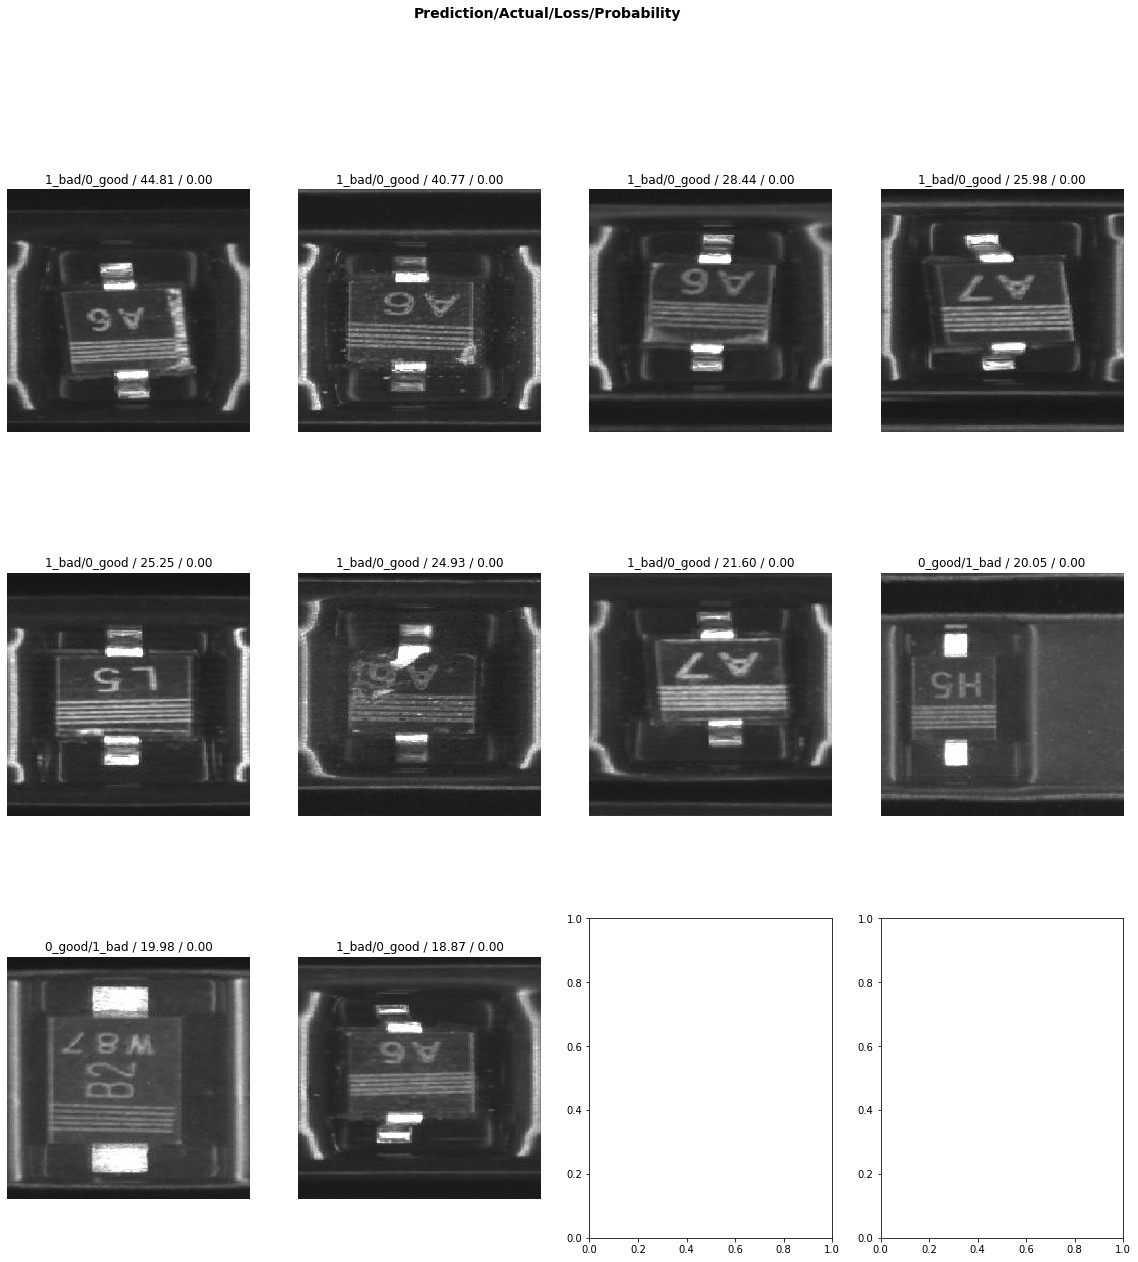

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()
interp.plot_top_losses(10, figsize=(20,20))

In [23]:
test_data = ImageDataBunch.from_folder("/home/abnv/math6380o/project_2", test="test")

/home/abnv/anaconda3/envs/math6380o/lib/python3.7/site-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [24]:
test_data

ImageDataBunch;

Train: LabelList (30000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1_bad,1_bad,1_bad,1_bad,1_bad
Path: /home/abnv/math6380o/project_2;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/abnv/math6380o/project_2;

Test: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/abnv/math6380o/project_2

In [5]:
learn

NameError: name 'learn' is not defined

In [2]:
tfms = get_transforms(
    do_flip = True, 
    flip_vert = True, 
    max_rotate = None,
    max_warp = None
)

In [3]:
len(tfms)

2

In [4]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [5]:
def get_ex(): return open_image('/home/abnv/math6380o/project_2/train/0_good/fff8bff51c6abce490fd85d2d1222be0.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]


In [6]:
os.getcwd()

'/home/abnv/PycharmProjects/math6380o/project2'

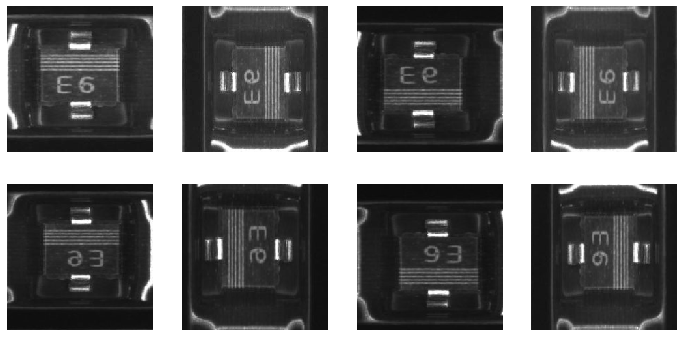

In [7]:
plots_f(2, 4, 12, 6, size=224)

In [321]:
data_transformed = ImageDataBunch.from_folder("/home/abnv/math6380o/project_2/data/train", 
                                              valid_pct=0.2, ds_tfms = tfms).normalize(imagenet_stats)


In [322]:
learn2 = cnn_learner(
    data_transformed, 
    models.resnet18, 
    metrics=[error_rate], 
    opt_func = optim.Adam
)

In [15]:
callbacks = [
    callbacks.OverSamplingCallback(learn2),
    callbacks.ReduceLROnPlateauCallback(learn2, monitor="valid_loss", mode="auto", patience=3, min_delta=0.01),
    callbacks.SaveModelCallback(
        learn2, 
        monitor="error_rate", 
        mode="min", 
        every="improvement", 
        name="transformed_best"
    )
]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04
Min loss divided by 10: 5.25E-04


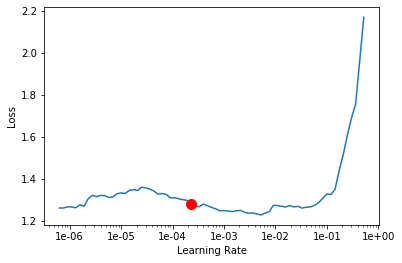

In [16]:
learn2.lr_find()
learn2.recorder.plot(suggestion=True)

In [17]:
learn2.fit_one_cycle(5, max_lr=slice(3e-5, 4e-3), callbacks=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,0.668094,0.663939,0.392833,00:40
1,0.605644,0.593640,0.293500,00:40
2,0.554379,0.399683,0.148833,00:40
3,0.519722,0.463843,0.191167,00:40
4,0.504302,0.461013,0.191500,00:40


Better model found at epoch 0 with error_rate value: 0.39283332228660583.
Better model found at epoch 1 with error_rate value: 0.29350000619888306.
Better model found at epoch 2 with error_rate value: 0.14883333444595337.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 7.59E-06


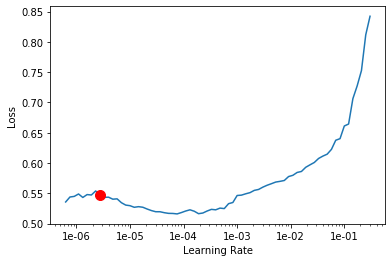

In [18]:
learn2.unfreeze()
learn2.lr_find()
learn2.recorder.plot(suggestion=True)

In [19]:
learn2.fit(5, slice(3e-6, 6e-5), callbacks=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,0.404967,0.389077,0.157500,00:54
1,0.310072,0.358489,0.144167,00:54
2,0.261563,0.245234,0.083333,00:55
3,0.241960,0.219879,0.076667,00:55
4,0.201025,0.206328,0.074167,00:55


Better model found at epoch 0 with error_rate value: 0.1574999988079071.
Better model found at epoch 1 with error_rate value: 0.14416666328907013.
Better model found at epoch 2 with error_rate value: 0.0833333358168602.
Better model found at epoch 3 with error_rate value: 0.07666666805744171.
Better model found at epoch 4 with error_rate value: 0.0741666629910469.


In [23]:
callbacks = [
    OverSamplingCallback(learn2),
    ReduceLROnPlateauCallback(learn2, monitor="valid_loss", mode="auto", patience=3, min_delta=0.01),
    SaveModelCallback(
        learn2, 
        monitor="error_rate", 
        mode="min", 
        every="improvement", 
        name="tsfmd_best_attempt_2"
    )
]

In [ ]:
learn2.fit(5, slice(3e-6, 6e-5), callbacks=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,0.187493,0.187158,0.061667,00:54
1,0.174741,0.175367,0.055667,00:54


Better model found at epoch 0 with error_rate value: 0.061666667461395264.
Better model found at epoch 1 with error_rate value: 0.055666666477918625.


In [26]:
callbacks = [
    OverSamplingCallback(learn2),
    ReduceLROnPlateauCallback(learn2, monitor="valid_loss", mode="auto", patience=3, min_delta=0.01),
    SaveModelCallback(
        learn2, 
        monitor="error_rate", 
        mode="min", 
        every="epoch", 
        name="tsfmd_best_attempt_3"
    )
]

In [27]:
learn2.fit(5, slice(3e-6, 6e-5), callbacks=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,0.121333,0.142942,0.043000,00:54
1,0.116324,0.137925,0.042500,00:55
2,0.099701,0.128936,0.036167,00:55
3,0.105964,0.135914,0.040500,00:55
4,0.092356,0.178819,0.056833,00:55


In [30]:
callbacks = [
    OverSamplingCallback(learn2),
    ReduceLROnPlateauCallback(learn2, monitor="error_rate", mode="auto", patience=2, min_delta=0.001),
    SaveModelCallback(
        learn2, 
        monitor="error_rate", 
        mode="min", 
        every="epoch", 
        name="tsfmd_best_attempt_4"
    )
]

In [31]:
learn2.fit(5, slice(3e-6, 6e-5), callbacks=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,0.080773,0.134883,0.037833,00:54
1,0.083851,0.128187,0.029833,00:55
2,0.080043,0.121969,0.032000,00:55
3,0.076529,0.124763,0.032167,00:54
4,0.070349,0.136952,0.036333,00:55


In [42]:
data_transformed.train_dl.dl.num_workers

16

In [46]:
callbacks = [
    OverSamplingCallback(learn2),
    ReduceLROnPlateauCallback(learn2, monitor="error_rate", mode="auto", patience=2, min_delta=0.001),
    SaveModelCallback(
        learn2, 
        monitor="error_rate", 
        mode="min", 
        every="epoch", 
        name="tsfmd_best_attempt_5"
    ),
    ShowGraph(learn2)
]

In [14]:
learn2.load("tsfmd_best_attempt_5_0")

Learner(data=ImageDataBunch;

Train: LabelList (24000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1_bad,1_bad,1_bad,1_bad,1_bad
Path: /home/abnv/math6380o/project_2/train;

Valid: LabelList (6000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0_good,0_good,0_good,0_good,0_good
Path: /home/abnv/math6380o/project_2/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchN

In [15]:
callbacks = [
    OverSamplingCallback(learn2),
    ReduceLROnPlateauCallback(learn2, monitor="error_rate", mode="auto", patience=2, min_delta=0.001),
    SaveModelCallback(
        learn2, 
        monitor="error_rate", 
        mode="min", 
        every="epoch", 
        name="tsfmd_best_attempt_6"
    ),
    ShowGraph(learn2)
]

epoch,train_loss,valid_loss,error_rate,time
0,0.105707,0.060525,0.017667,00:40
1,0.105026,0.059208,0.016667,00:39
2,0.113462,0.061381,0.018000,00:39
3,0.097836,0.059233,0.017500,00:39
4,0.096779,0.059720,0.017167,00:39


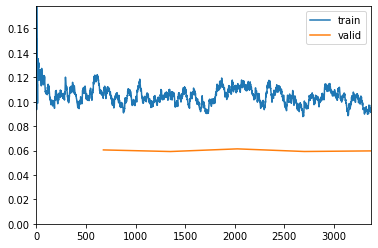

In [16]:
learn2.fit(5, slice(1e-6, 6e-5), callbacks=callbacks)

In [18]:
callbacks = [
    OverSamplingCallback(learn2),
    ReduceLROnPlateauCallback(learn2, monitor="valid_loss", mode="auto", patience=2, min_delta=0.001),
    SaveModelCallback(
        learn2, 
        monitor="error_rate", 
        mode="min", 
        every="epoch", 
        name="tsfmd_best_attempt_7"
    ),
    ShowGraph(learn2)
]

epoch,train_loss,valid_loss,error_rate,time
0,0.102567,0.057358,0.015833,00:39
1,0.095416,0.060235,0.016167,00:39
2,0.100217,0.054701,0.015000,00:39
3,0.104706,0.062408,0.017500,00:39


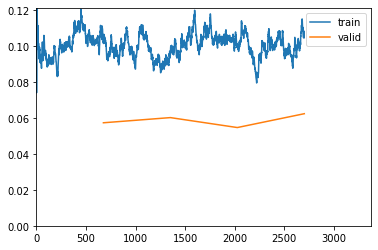

RuntimeError: DataLoader worker (pid 7212) is killed by signal: Aborted. 

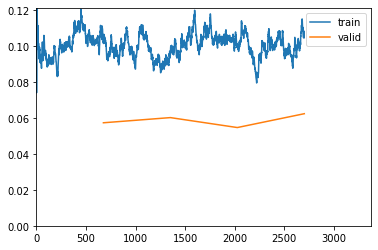

In [19]:
learn2.fit(5, slice(1e-6, 6e-5), callbacks=callbacks)

In [21]:
callbacks = [
    OverSamplingCallback(learn2),
    ReduceLROnPlateauCallback(learn2, monitor="valid_loss", mode="auto", patience=2, min_delta=0.001),
    SaveModelCallback(
        learn2, 
        monitor="error_rate", 
        mode="min", 
        every="epoch", 
        name="tsfmd_best_attempt_8"
    ),
    ShowGraph(learn2)
]

epoch,train_loss,valid_loss,error_rate,time
0,0.098230,0.053166,0.014833,00:40
1,0.095197,0.065787,0.018667,00:39
2,0.093819,0.055886,0.015333,00:39
3,0.092917,0.059373,0.016333,00:39
4,0.098404,0.070006,0.019833,00:40


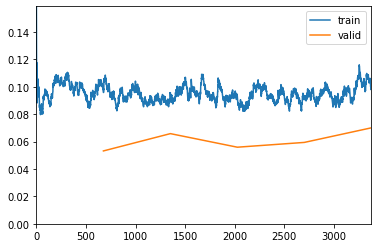

In [22]:
learn2.fit(5, slice(1e-6, 6e-5), callbacks=callbacks)

In [30]:
callbacks = [
    OverSamplingCallback(learn2),
    ReduceLROnPlateauCallback(learn2, monitor="valid_loss", mode="auto", patience=2, min_delta=0.001),
    SaveModelCallback(
        learn2, 
        monitor="error_rate", 
        mode="min", 
        every="epoch", 
        name="tsfmd_best_attempt_9"
    ),
    ShowGraph(learn2)
]

epoch,train_loss,valid_loss,error_rate,time
0,0.095005,0.065884,0.019667,00:39
1,0.098516,0.053782,0.013833,00:39
2,0.092711,0.064659,0.018500,00:39
3,0.097096,0.058411,0.016667,00:39
4,0.090429,0.064900,0.018167,00:39


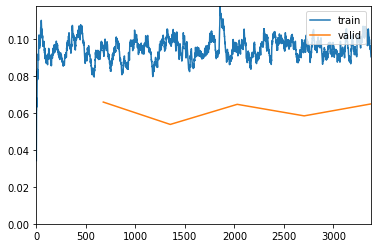

In [31]:
learn2.fit(5, slice(1e-6, 6e-5), callbacks=callbacks)

In [36]:
callbacks = [
    OverSamplingCallback(learn2),
    ReduceLROnPlateauCallback(learn2, monitor="valid_loss", mode="auto", patience=2, min_delta=0.001),
    SaveModelCallback(
        learn2, 
        monitor="error_rate", 
        mode="min", 
        every="epoch", 
        name="tsfmd_best_attempt_11"
    ),
    ShowGraph(learn2)
]

epoch,train_loss,valid_loss,error_rate,time
0,0.093421,0.063537,0.018833,00:39
1,0.095007,0.074382,0.021000,00:39
2,0.091971,0.057379,0.016167,00:39
3,0.083380,0.056309,0.015500,00:39
4,0.092322,0.060242,0.016000,00:39
5,0.087225,0.057662,0.016500,00:39


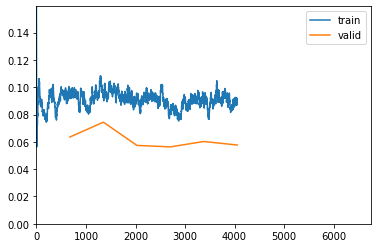

In [ ]:
learn2.fit(10, slice(1e-6, 6e-5), callbacks=callbacks)

In [323]:
learn2 = cnn_learner(
    data_transformed, 
    models.resnet18, 
    metrics=[error_rate, AUROC()], 
    opt_func = optim.Adam
)

In [324]:
learn2.load("/home/abnv/math6380o/project_2/models/tsfmd_best_attempt_9_1")

Learner(data=ImageDataBunch;

Train: LabelList (24000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1_bad,1_bad,1_bad,1_bad,1_bad
Path: /home/abnv/math6380o/project_2/data/train;

Valid: LabelList (6000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0_good,0_good,0_good,0_good,0_good
Path: /home/abnv/math6380o/project_2/data/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn

In [116]:
callbacks = [
    OverSamplingCallback(learn2),
    ReduceLROnPlateauCallback(learn2, monitor="valid_loss", mode="auto", patience=2, min_delta=0.001),
    SaveModelCallback(
        learn2, 
        monitor="error_rate", 
        mode="min", 
        every="epoch", 
        name="tsfmd_best_w_auc_1"
    ),
    ShowGraph(learn2),
    AUROC()
]

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.096418,0.066288,0.018167,0.992663,00:40
1,0.092614,0.060925,0.017333,0.992848,00:40
2,0.100597,0.056284,0.015333,0.993021,00:40
3,0.088534,0.065060,0.018667,0.992610,00:40
4,0.099977,0.056166,0.015000,0.992877,00:40


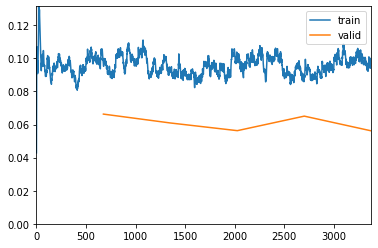

In [117]:
learn2.fit(5, slice(1e-6, 6e-5), callbacks=callbacks)

In [199]:
preds = learn2.TTA()
preds[0][:5, :].numpy()

array([[0.744311, 0.255689],
       [0.519349, 0.480651],
       [0.729826, 0.270174],
       [0.630326, 0.369674],
       [0.618602, 0.381398]], dtype=float32)

In [206]:
blah = preds[0][:10, :].numpy(); blah

array([[0.744311, 0.255689],
       [0.519349, 0.480651],
       [0.729826, 0.270174],
       [0.630326, 0.369674],
       [0.618602, 0.381398],
       [0.645956, 0.354044],
       [0.822866, 0.177134],
       [0.725165, 0.274835],
       [0.783959, 0.216041],
       [0.681616, 0.318384]], dtype=float32)

In [207]:
result = np.argmax(blah, axis=1); print(result)

[0 0 0 0 0 0 0 0 0 0]


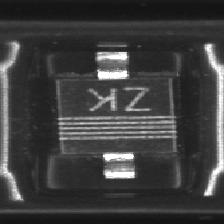

In [187]:
data_transformed.train_ds.x[4001]

In [189]:
learn2.predict(data_transformed.train_ds.x[1001])

(Category 1_bad, tensor(1), tensor([0.0012, 0.9988]))

In [121]:
data_transformed.train_dl.dataset.items

array([PosixPath('/home/abnv/math6380o/project_2/train/1_bad/b9a063ee0ebc5af10407f40479e3eb50.jpg'),
       PosixPath('/home/abnv/math6380o/project_2/train/1_bad/c40d13f0ef6ec91dbce2acc0a4e76995.jpg'),
       PosixPath('/home/abnv/math6380o/project_2/train/1_bad/4e72495ec13d1a52402121c8a148136f.jpg'),
       PosixPath('/home/abnv/math6380o/project_2/train/1_bad/95d06c486be63868f8539f933a133502.jpg'), ...,
       PosixPath('/home/abnv/math6380o/project_2/train/0_good/7a8acfdf126752956d5534808808fbb2.jpg'),
       PosixPath('/home/abnv/math6380o/project_2/train/0_good/3ded94db3b38956b5d646831d6f55b8e.jpg'),
       PosixPath('/home/abnv/math6380o/project_2/train/0_good/9084d70a17703840a6d6556ad268644d.jpg'),
       PosixPath('/home/abnv/math6380o/project_2/train/0_good/d3751eb81adf5ceb674ef6e327acffd2.jpg')], dtype=object)

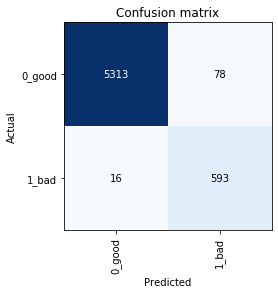

In [325]:
interp2 = ClassificationInterpretation.from_learner(learn2)

interp2.plot_confusion_matrix()

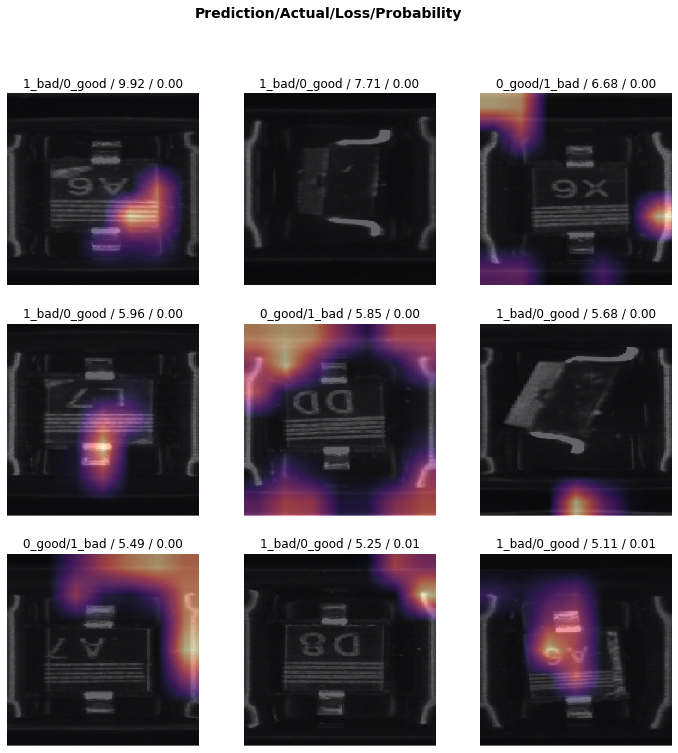

In [326]:
interp2.plot_top_losses(9, heatmap=True)

## Train on entire dataset

In [301]:
tfms = get_transforms(
    do_flip = True, 
    flip_vert = True, 
    max_rotate = None,
    max_warp = None
)

In [302]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [303]:
train_data = ImageDataBunch.from_folder(
    "/home/abnv/math6380o/project_2/data", train = "train", test = "test", 
    ds_tfms = tfms, valid_pct=0.0001).normalize(imagenet_stats)

In [304]:
train_data.classes

['0_good', '1_bad']

In [305]:
learn_full = cnn_learner(
    train_data, 
    models.resnet18, 
    metrics=[error_rate], 
    opt_func = optim.Adam
)

In [306]:
learn_full.load("/home/abnv/math6380o/project_2/models/train_full_4")

Learner(data=ImageDataBunch;

Train: LabelList (29997 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1_bad,1_bad,1_bad,1_bad,1_bad
Path: /home/abnv/math6380o/project_2/data;

Valid: LabelList (3 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0_good,0_good,0_good
Path: /home/abnv/math6380o/project_2/data;

Test: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/abnv/math6380o/project_2/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
  

In [229]:
from fastai import callbacks

callbacks = [
    OverSamplingCallback(learn_full),
    ReduceLROnPlateauCallback(learn_full, monitor="valid_loss", mode="auto", patience=3, min_delta=0.01),
    SaveModelCallback(
        learn_full, 
        monitor="error_rate", 
        mode="min", 
        every="epoch", 
        name="train_full"
    ),
    ShowGraph(learn_full)
]

In [231]:
learn_full.freeze()

In [232]:
learn_full.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

epoch,train_loss,valid_loss,error_rate,time
0,0.107270,0.037040,0.000000,00:45
1,0.101330,0.041855,0.000000,00:45
2,0.095214,0.071202,0.000000,00:45
3,0.102647,0.032724,0.000000,00:45
4,0.089108,0.033226,0.000000,00:45


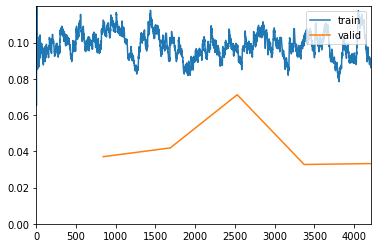

In [233]:
learn_full.fit(5, slice(1e-6, 6e-5), callbacks=callbacks)

# Now to test!

In [307]:
probs, labels = learn_full.TTA(ds_type=DatasetType.Test, scale = 1.1)

In [308]:
probs.shape

torch.Size([3000, 2])

In [309]:
preds = np.argmax(probs, axis=1)

In [310]:
preds.shape

torch.Size([3000])

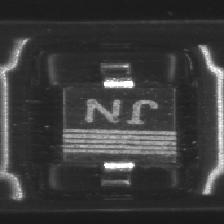

In [311]:
train_data.test_ds.x[-100]

In [312]:
paths = list(map(lambda x: str(x).split("/")[-1], train_data.test_ds.x.items))

In [313]:
filenames =  list(map(lambda x: x.split(".")[0], paths))

In [314]:
zip(filenames, preds.numpy())

In [315]:
import pandas as pd

In [316]:
df = pd.DataFrame(list(zip(filenames, preds.numpy())), columns = ["id", "label"])

In [317]:
df.head()

,id,label
0,e182b20c161d94a3e491c3fa36868c62,0
1,15833f01d63f314c8b38534da14a4116,0
2,1ac6ef5ff3662112d9f8e8bd9282feb7,0
3,b33816010f160db6a4016030b0d181ce,0
4,0f144f07e71c21265065d5eb7359836c,0


In [318]:
df.to_csv("/home/abnv/math6380o/project_2/submission_4.csv", index=False)